# Financial Anomaly Detection Using LSTM Autoencoder

This notebook implements an advanced anomaly detection system for financial time series data using deep learning techniques and domain-specific knowledge.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

# Set up device for PyTorch (using MPS for M4 Max)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset
file_path = "Dataset4_EWS.xlsx"
# Load the markets data from the first sheet
df = pd.read_excel(file_path, sheet_name="Markets", parse_dates=['Data'])
# Load metadata for reference
metadata = pd.read_excel(file_path, sheet_name="Metadata")

# Display basic information
print(f"Dataset loaded with shape: {df.shape}")
print(f"Time range: {df['Data'].min()} to {df['Data'].max()}")
print(f"Number of features: {df.shape[1] - 2}")  # Excluding Data and Y columns
print(f"Class distribution:")
print(df['Y'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

Using device: mps
Dataset loaded with shape: (1111, 44)
Time range: 2000-01-11 00:00:00 to 2021-04-20 00:00:00
Number of features: 42
Class distribution:
Y
0    78.67%
1    21.33%
Name: proportion, dtype: object


## Exploratory Data Analysis

Let's explore the dataset to understand its structure, feature distributions, and identify patterns in normal vs anomalous periods.

Sample data:


,Data,BDIY,CRY,Cl1,DXY,ECSURPUS,EMUSTRUU,EONIA,GBP,GT10,...,MXJP,MXRU,MXUS,US0001M,USGG2YR,USGG30YR,USGG3M,VIX,XAUBGNL,Y
0,2000-01-11,1388,157.26,25.77,100.56,0.077,230.5267,2.89,1.6460,6.657,...,990.59,224.33,1416.12,5.78125,6.428,6.671,5.426,22.50,283.25,0
1,2000-01-18,1405,165.01,28.85,101.86,0.043,231.3770,3.03,1.6383,6.748,...,993.98,234.37,1428.79,5.80250,6.465,6.747,5.378,21.50,287.65,0
2,2000-01-25,1368,167.24,28.28,102.41,0.135,232.3895,3.15,1.6496,6.692,...,974.83,216.82,1385.93,5.81875,6.432,6.634,5.562,23.02,287.15,0
3,2000-02-01,1311,166.85,28.22,104.92,0.191,231.9417,3.30,1.6106,6.619,...,1007.12,201.89,1385.31,5.88500,6.574,6.423,5.708,23.45,282.75,0
4,2000-02-08,1277,165.43,28.02,104.22,0.312,237.8117,3.26,1.6108,6.613,...,1034.58,218.00,1411.95,5.89125,6.678,6.231,5.677,21.25,298.40,1



Missing values per column:
No missing values

Basic statistics for numerical features:


,Data,BDIY,CRY,Cl1,DXY,ECSURPUS,EMUSTRUU,EONIA,GBP,GT10,...,MXJP,MXRU,MXUS,US0001M,USGG2YR,USGG30YR,USGG3M,VIX,XAUBGNL,Y
count,1111,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,2010-08-31 00:00:00,2259.860486,245.247649,60.708101,90.934982,0.036153,704.379495,1.363676,1.569618,3.266748,...,784.846292,648.681377,1606.997102,1.836073,1.990358,3.908324,1.575151,19.992169,987.463744,0.213321
min,2000-01-11 00:00:00,291.000000,106.292900,10.010000,71.329000,-0.974000,230.526700,-0.498000,1.172300,0.508000,...,431.710000,151.250000,663.690000,0.105750,0.107300,1.162600,-0.038100,9.430000,256.680000,0.000000
25%,2005-05-06 12:00:00,990.000000,184.705650,39.625000,81.240500,-0.191000,434.660700,-0.229500,1.417900,2.195500,...,601.615000,463.195000,1103.925000,0.241250,0.576200,2.959550,0.090250,13.640000,433.740000,0.000000
50%,2010-08-31 00:00:00,1518.000000,234.560000,57.400000,89.716000,0.035000,714.807100,0.437000,1.562200,3.115000,...,786.830000,612.930000,1324.430000,1.213890,1.522300,4.100400,0.957800,17.980000,1137.800000,0.000000
75%,2015-12-25 12:00:00,2685.500000,301.539250,79.640000,97.404000,0.260500,939.824600,2.890000,1.677050,4.345000,...,965.875000,793.620000,1992.445000,2.502220,2.927450,4.844600,2.335650,23.625000,1324.825000,0.000000
max,2021-04-20 00:00:00,11793.000000,467.570000,140.970000,119.820000,0.991000,1286.353000,5.730000,2.085200,6.748000,...,1210.580000,1617.640000,4043.690000,6.776250,6.872000,6.747000,6.414000,75.910000,2006.910000,1.000000
std,NaN,2017.811888,68.278081,25.900813,11.379095,0.349453,309.951768,1.721894,0.212340,1.332464,...,200.076443,299.096020,698.481956,1.909032,1.710307,1.178592,1.802895,8.642157,494.623740,0.409837


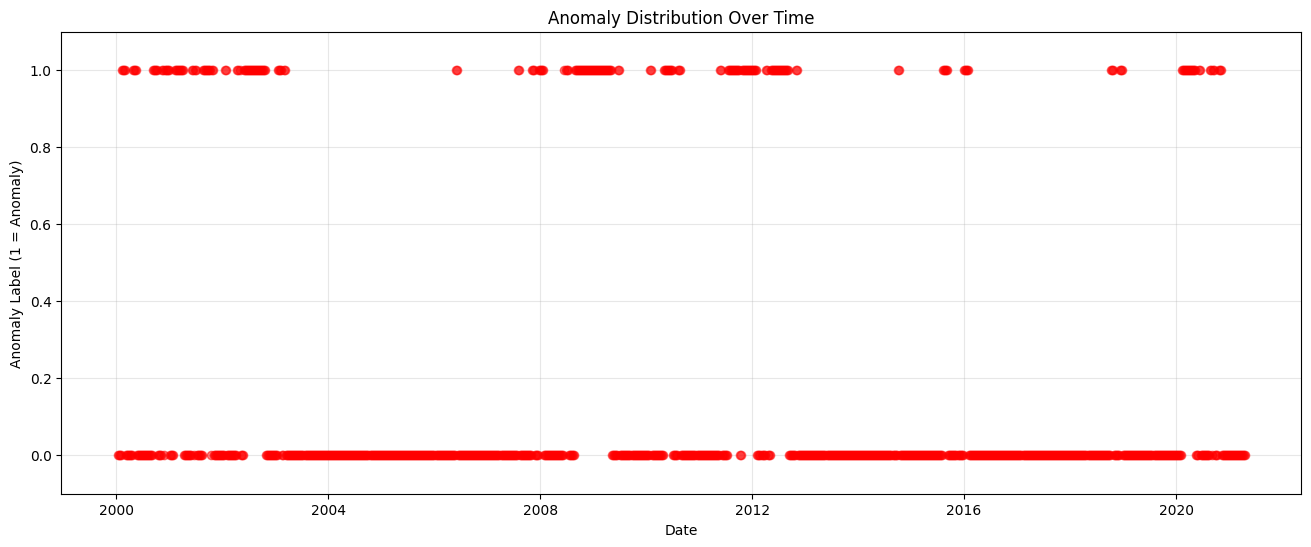


Identified Crisis Periods:
From 2000-02-08 to 2000-02-29 (3 weeks)
From 2000-04-25 to 2000-05-16 (3 weeks)
From 2000-09-12 to 2000-10-10 (4 weeks)
From 2000-11-14 to 2000-11-21 (1 weeks)
From 2000-12-05 to 2001-01-02 (4 weeks)
From 2001-02-06 to 2001-04-03 (8 weeks)
From 2001-06-05 to 2001-06-12 (1 weeks)
From 2001-06-26 to 2001-07-03 (1 weeks)
From 2001-08-21 to 2001-10-09 (7 weeks)
From 2001-10-23 to 2001-10-30 (1 weeks)
From 2002-01-22 to 2002-01-29 (1 weeks)
From 2002-04-16 to 2002-04-30 (2 weeks)
From 2002-05-28 to 2002-10-22 (21 weeks)
From 2003-01-21 to 2003-02-11 (3 weeks)
From 2003-03-04 to 2003-03-11 (1 weeks)
From 2006-05-30 to 2006-06-06 (1 weeks)
From 2007-07-31 to 2007-08-07 (1 weeks)
From 2007-11-06 to 2007-11-20 (2 weeks)
From 2007-12-25 to 2008-01-22 (4 weeks)
From 2008-06-17 to 2008-07-08 (3 weeks)
From 2008-08-26 to 2009-05-05 (36 weeks)
From 2009-06-23 to 2009-06-30 (1 weeks)
From 2010-01-26 to 2010-02-02 (1 weeks)
From 2010-05-04 to 2010-06-29 (8 weeks)
From 2010-

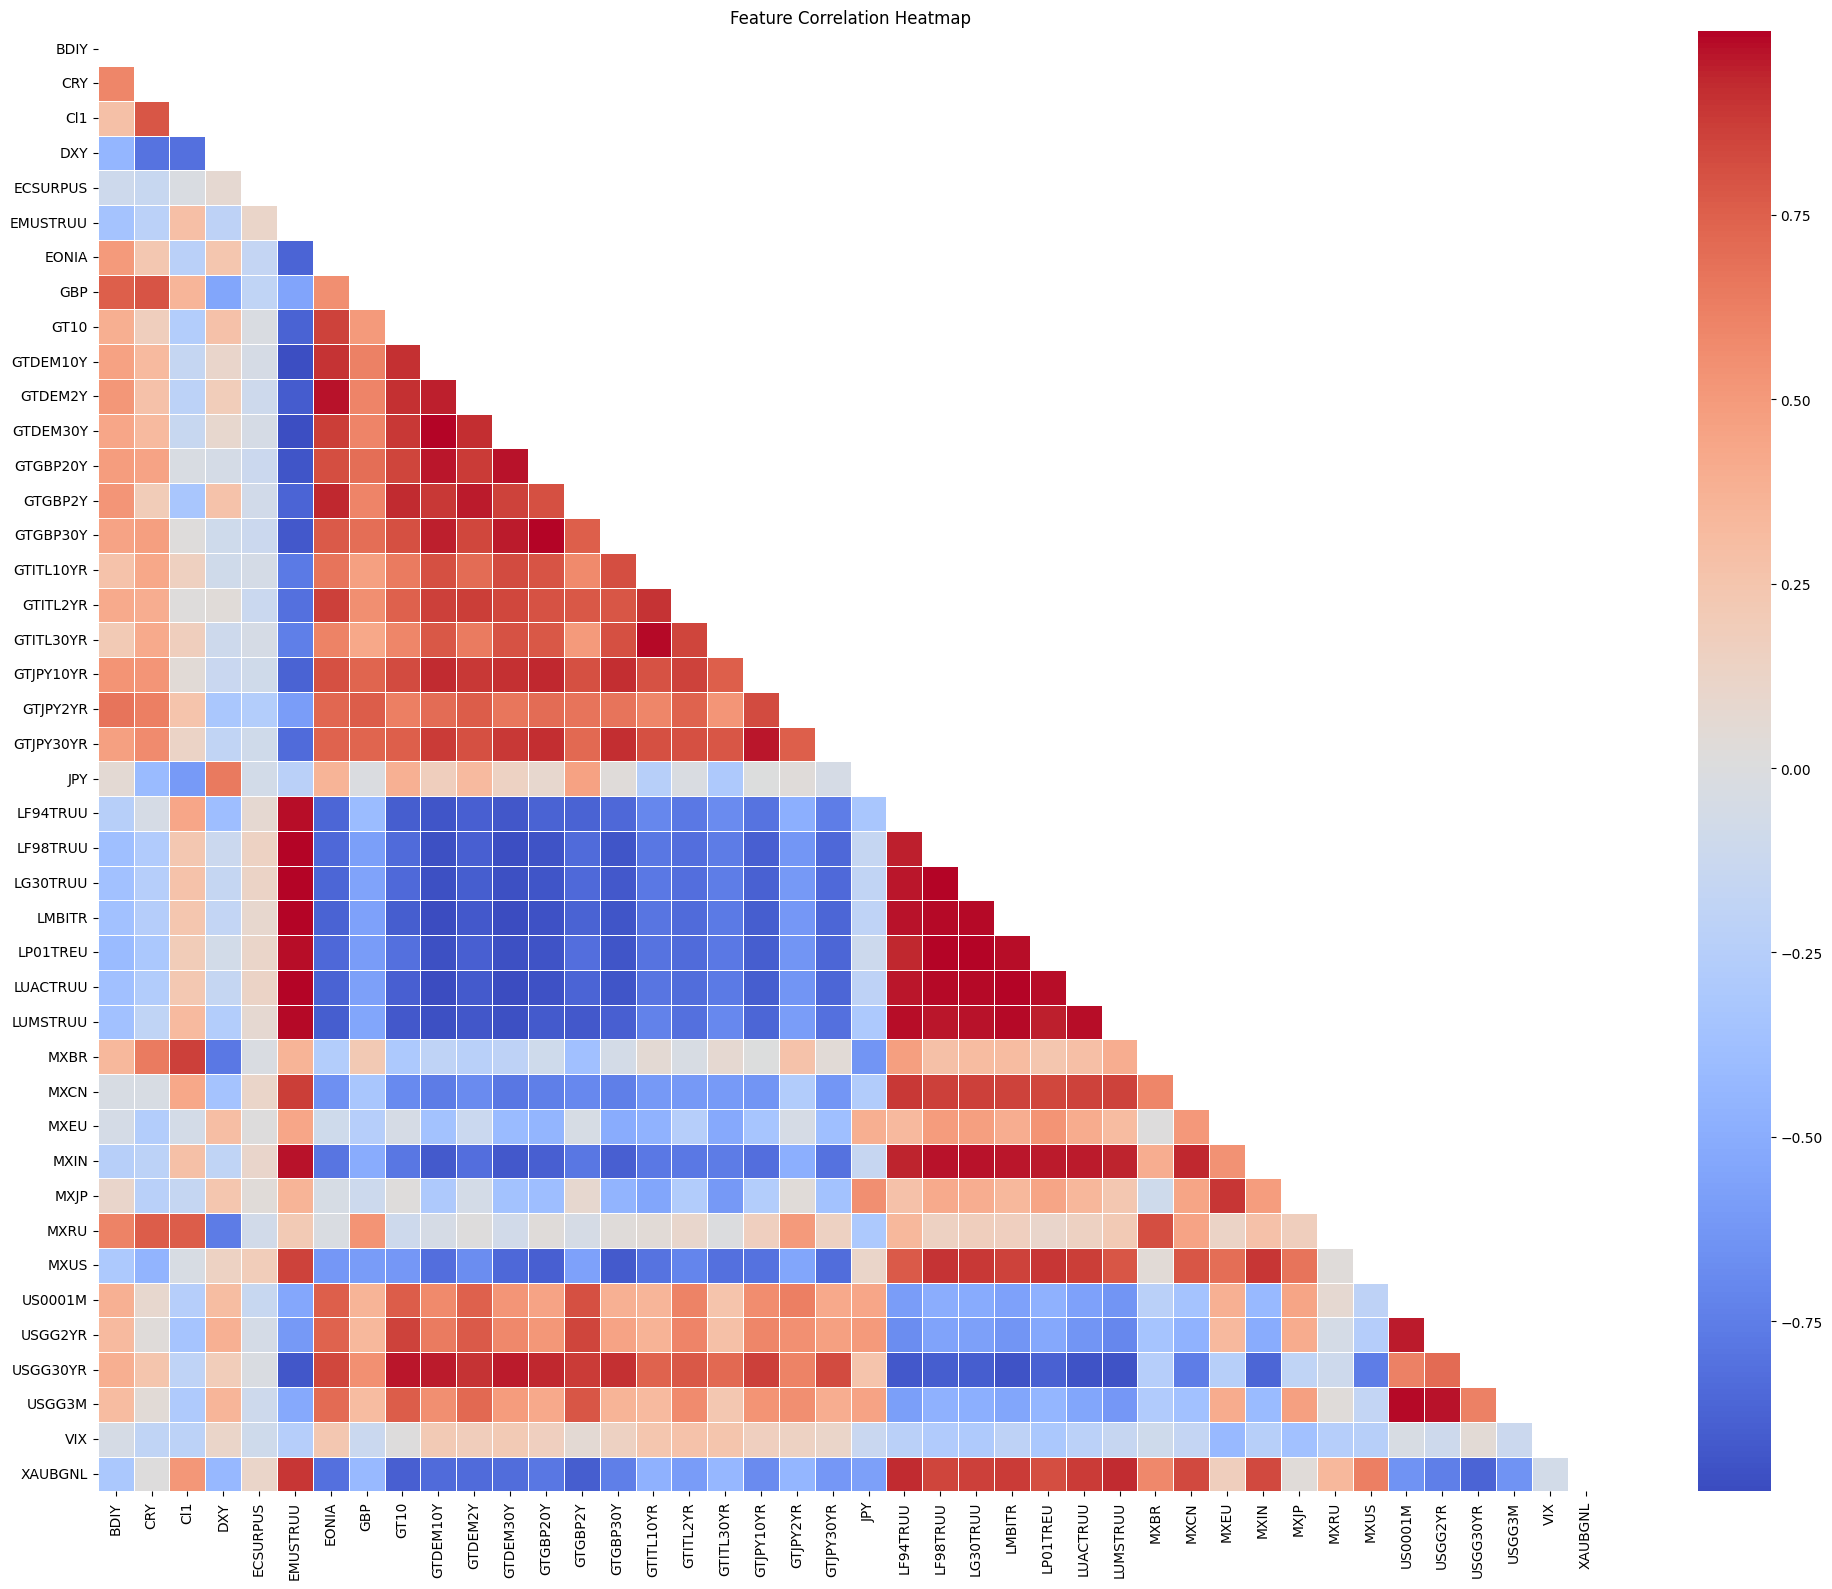

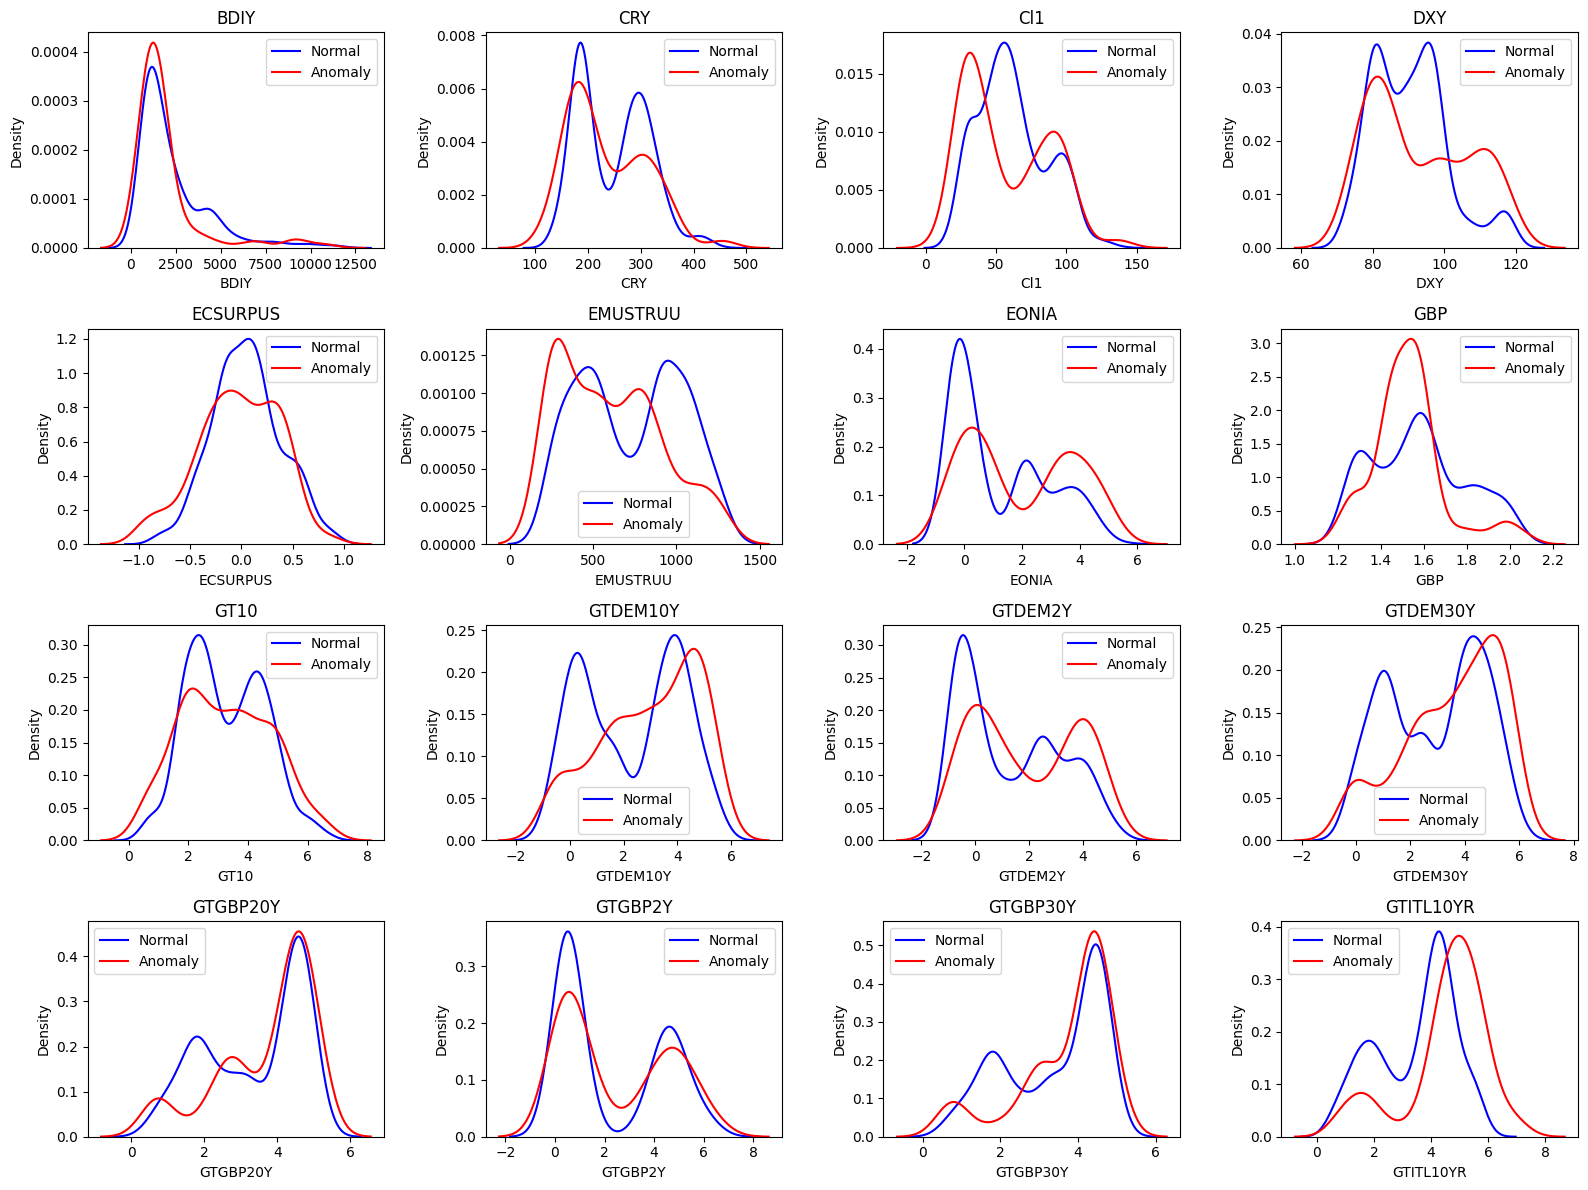

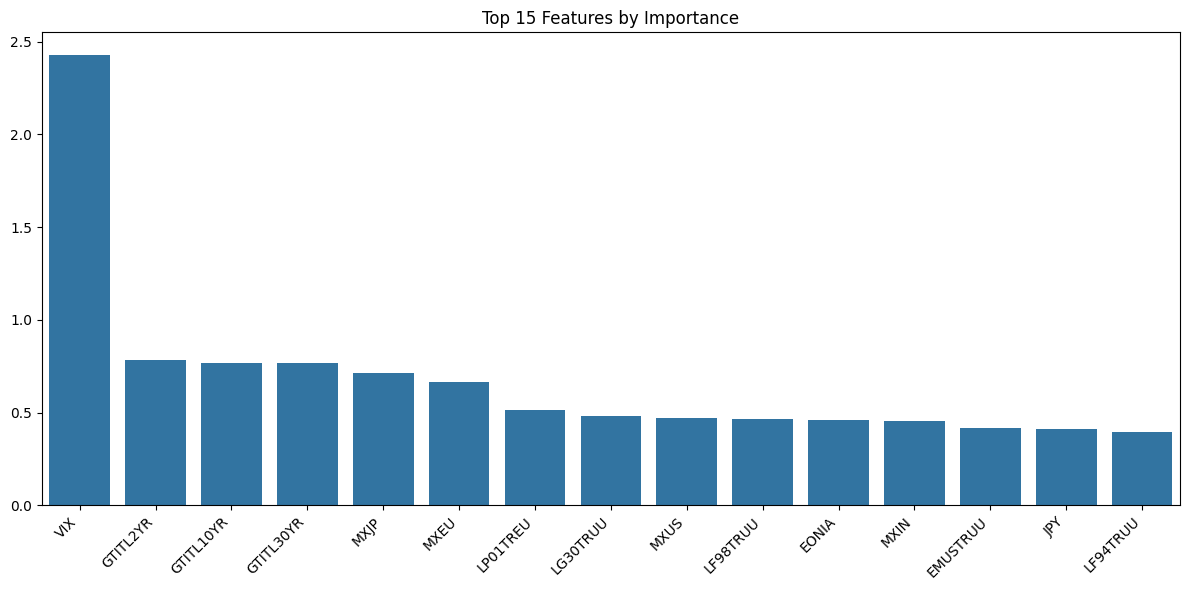

In [2]:
# Basic EDA
# Display first few rows
print("Sample data:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

# Basic statistics
print("\nBasic statistics for numerical features:")
display(df.describe())

# Plot the distribution of target variable over time
plt.figure(figsize=(16, 6))
plt.plot(df['Data'], df['Y'], 'ro', alpha=0.5)
plt.title('Anomaly Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Anomaly Label (1 = Anomaly)')
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()

# Visualize crisis periods (continuous anomaly sequences)
crisis_starts = []
crisis_ends = []
in_crisis = False

for i, (date, label) in enumerate(zip(df['Data'], df['Y'])):
    if label == 1 and not in_crisis:
        crisis_starts.append(date)
        in_crisis = True
    elif label == 0 and in_crisis:
        crisis_ends.append(df['Data'].iloc[i-1])
        in_crisis = False

# Add the last crisis end if dataset ends during a crisis
if in_crisis:
    crisis_ends.append(df['Data'].iloc[-1])

print("\nIdentified Crisis Periods:")
for start, end in zip(crisis_starts, crisis_ends):
    duration = (end - start).days // 7  # Duration in weeks
    print(f"From {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} weeks)")

# Plot feature correlation heatmap
plt.figure(figsize=(20, 16))
features = df.drop(['Data', 'Y'], axis=1).columns
correlation = df[features].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Analyze feature distributions by class
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features[:16]):  # Plot first 16 features
    plt.subplot(4, 4, i+1)
    sns.kdeplot(df[df['Y'] == 0][feature], label='Normal', color='blue')
    sns.kdeplot(df[df['Y'] == 1][feature], label='Anomaly', color='red')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()

# Calculate feature importance based on difference between normal and anomaly distributions
feature_importance = {}
for feature in features:
    normal_mean = df[df['Y'] == 0][feature].mean()
    anomaly_mean = df[df['Y'] == 1][feature].mean()
    normal_std = df[df['Y'] == 0][feature].std()
    
    # Calculate standardized difference
    if normal_std > 0:
        diff = abs(normal_mean - anomaly_mean) / normal_std
        feature_importance[feature] = diff
    else:
        feature_importance[feature] = 0

# Plot top 15 features by importance
top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]
plt.figure(figsize=(12, 6))
sns.barplot(x=[f[0] for f in top_features], y=[f[1] for f in top_features])
plt.title('Top 15 Features by Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Financial Feature Engineering

In this section, we'll create domain-specific financial features to enhance our anomaly detection model. These include:
1. Price transformations (returns, volatility)
2. Technical indicators
3. Cross-asset relationships
4. Financial regime indicators
5. Yield curve features

Original dataframe shape: (1111, 44)
Enriched dataframe shape: (1085, 241)
Number of new features added: 197

Sample of new financial features:


,Data,Y,BDIY_ret,BDIY_zscore,BDIY_vol_4w,BDIY_vol_12w,CRY_ret,CRY_zscore,CRY_vol_4w,CRY_vol_12w,Cl1_ret,Cl1_zscore
0,2000-07-11,0,-0.005590,-0.654411,11.842719,25.617229,-0.023599,-1.271146,2.454479,5.974022,-0.086154,-1.442351
1,2000-07-18,0,0.015615,0.866025,12.124356,22.801349,0.035980,0.835384,2.905849,4.612888,0.075421,0.310359
2,2000-07-25,0,0.001845,0.941332,13.279056,23.496615,-0.050406,-1.156896,4.302460,3.626260,-0.124922,-1.225738
3,2000-08-01,0,0.009822,1.085695,18.191115,26.753080,-0.000056,-0.696372,4.505496,3.206961,-0.005725,-0.803924
4,2000-08-08,0,0.001216,0.950665,10.781929,29.527979,0.016342,-0.041611,4.506006,3.160885,0.047859,-0.041656


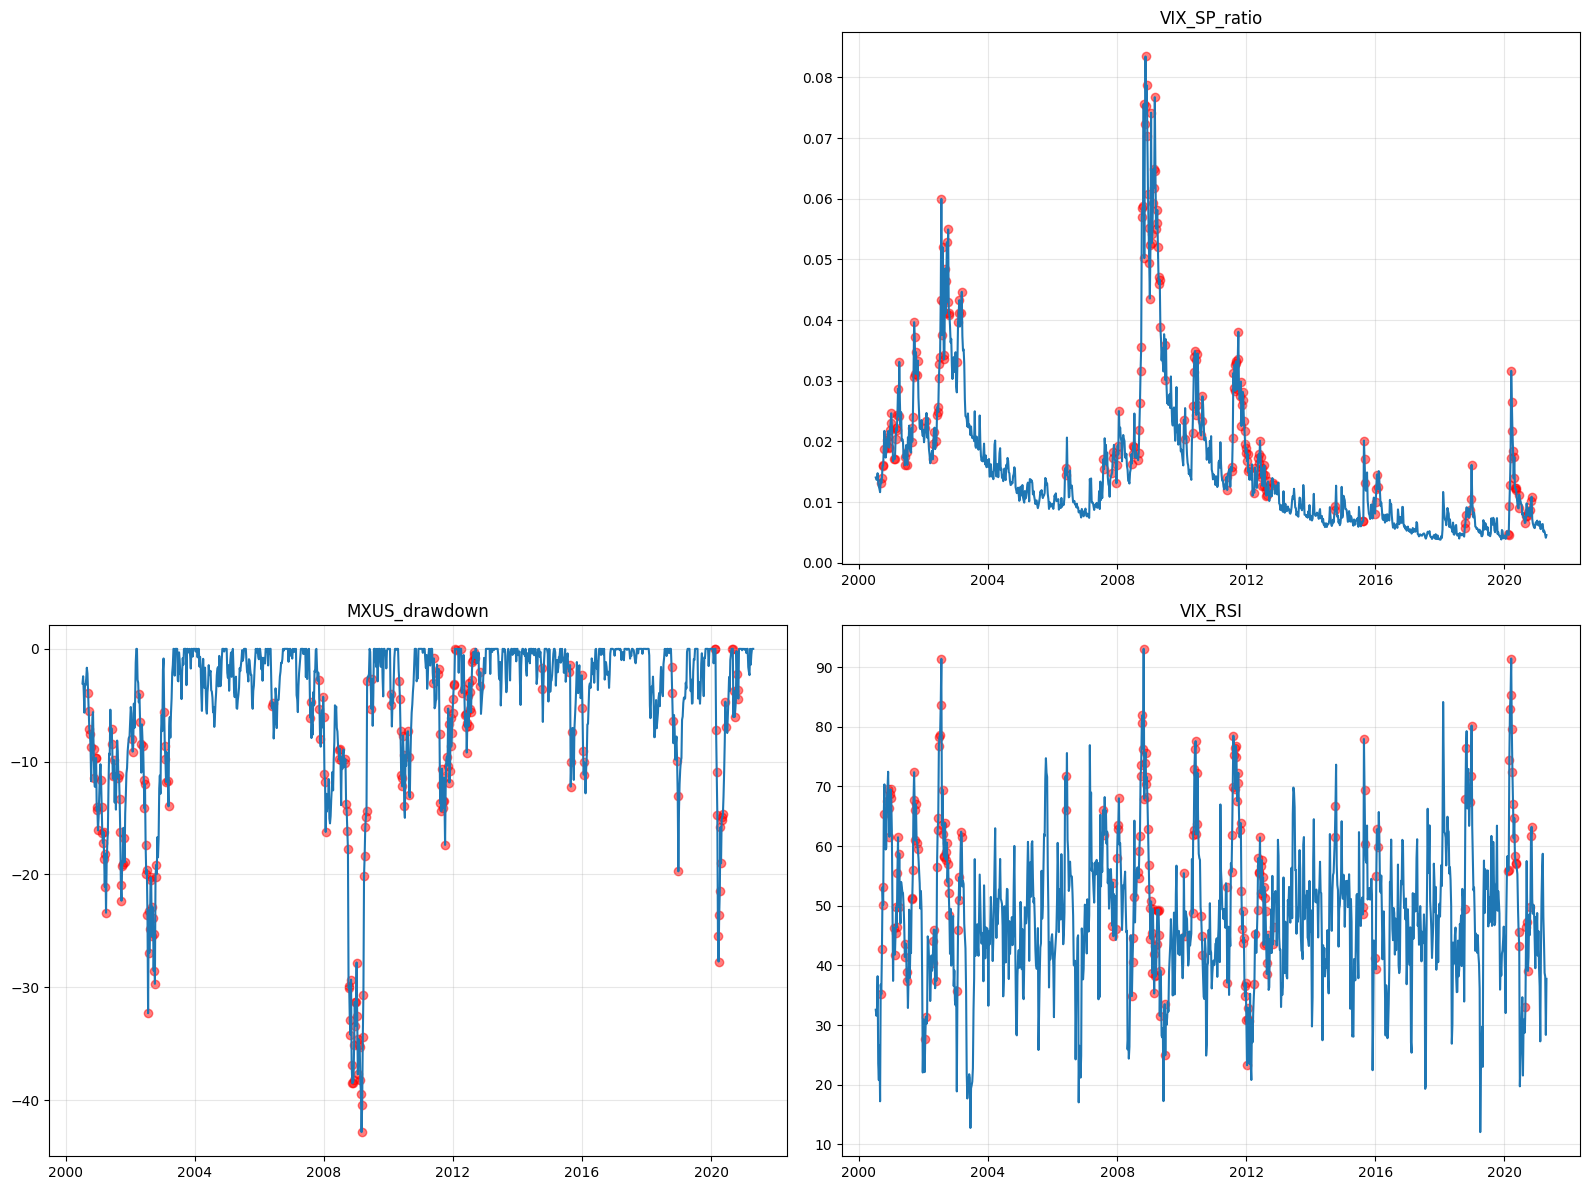

In [6]:
# Data preprocessing and financial feature engineering
from scipy import stats
import statsmodels.api as sm

def create_financial_features(df):
    """
    Create financial domain-specific features from the original data
    with optimized performance to avoid DataFrame fragmentation
    """
    # Make a copy of the dataframe with only the features (exclude Date and target)
    features = df.drop(['Data', 'Y'], axis=1).columns
    
    # Create dictionaries to store feature calculations
    new_features = {}
    
    # Precompute statistics for all features
    for feature in features:
        # Percentage returns
        new_features[f'{feature}_ret'] = df[feature].pct_change()
        
        # Calculate rolling statistics
        rolling_mean_4w = df[feature].rolling(window=4).mean()
        rolling_std_4w = df[feature].rolling(window=4).std()
        rolling_std_12w = df[feature].rolling(window=12).std()
        
        # Z-score
        z_scores = pd.Series(index=df.index)
        mask = rolling_std_4w > 0
        z_scores[mask] = (df[feature][mask] - rolling_mean_4w[mask]) / rolling_std_4w[mask]
        z_scores[~mask] = 0
        new_features[f'{feature}_zscore'] = z_scores
        
        # Volatility metrics
        new_features[f'{feature}_vol_4w'] = rolling_std_4w
        new_features[f'{feature}_vol_12w'] = rolling_std_12w
    
    # Technical indicators for select market indices
    market_indices = ['MXUS', 'MXEU', 'VIX']
    for idx in market_indices:
        if idx in features:
            # RSI (Relative Strength Index)
            delta = df[idx].diff()
            gain = delta.clip(lower=0)
            loss = -delta.clip(upper=0)
            avg_gain = gain.rolling(window=14).mean()
            avg_loss = loss.rolling(window=14).mean()
            
            # Handle division by zero in RSI calculation
            rs = pd.Series(index=df.index)
            mask = avg_loss > 0
            rs[mask] = avg_gain[mask] / avg_loss[mask]
            rs[~mask] = 100
            
            rsi = 100 - (100 / (1 + rs))
            new_features[f'{idx}_RSI'] = rsi.fillna(50)  # Fill NaN with neutral RSI value
            
            # MACD (Moving Average Convergence Divergence)
            ema12 = df[idx].ewm(span=12).mean()
            ema26 = df[idx].ewm(span=26).mean()
            new_features[f'{idx}_MACD'] = ema12 - ema26
            
            # Bollinger Bands
            rolling_mean = df[idx].rolling(window=20).mean()
            rolling_std = df[idx].rolling(window=20).std()
            new_features[f'{idx}_BB_upper'] = rolling_mean + (rolling_std * 2)
            new_features[f'{idx}_BB_lower'] = rolling_mean - (rolling_std * 2)
            
            # Bollinger Band width
            bb_width = pd.Series(index=df.index)
            mask = rolling_mean > 0
            bb_width[mask] = ((new_features[f'{idx}_BB_upper'][mask] - 
                             new_features[f'{idx}_BB_lower'][mask]) / 
                             rolling_mean[mask])
            bb_width[~mask] = 0
            new_features[f'{idx}_BB_width'] = bb_width
    
    # Cross-asset relationships
    if 'MXUS' in features and 'MXEU' in features:
        new_features['US_EU_corr'] = df['MXUS'].rolling(window=12).corr(df['MXEU'])
    
    if 'XAUBGNL' in features and 'MXUS' in features:
        new_features['Gold_SP_ratio'] = df['XAUBGNL'] / df['MXUS']
    
    if 'VIX' in features and 'MXUS' in features:
        new_features['VIX_SP_ratio'] = df['VIX'] / df['MXUS']
    
    # Yield curve features
    if 'USGG10YR' in features and 'USGG2YR' in features:
        new_features['US_10Y_2Y_spread'] = df['USGG10YR'] - df['USGG2YR']
    
    if 'USGG30YR' in features and 'USGG2YR' in features:
        new_features['US_30Y_2Y_spread'] = df['USGG30YR'] - df['USGG2YR']
    
    if 'GTDEM10Y' in features and 'GTDEM2Y' in features:
        new_features['GER_10Y_2Y_spread'] = df['GTDEM10Y'] - df['GTDEM2Y']
    
    # TED Spread (if available)
    if 'US0003M' in features and 'USGG3M' in features:
        new_features['TED_spread'] = df['US0003M'] - df['USGG3M']
    
    # Market regime indicators
    if 'VIX' in features:
        new_features['high_vol_regime'] = (df['VIX'] > 20).astype(int)
    
    # Trend indicator for major indices
    for idx in market_indices:
        if idx in features:
            new_features[f'{idx}_trend'] = (
                df[idx] > df[idx].rolling(window=12).mean()
            ).astype(int)
    
    # Calendar effects
    new_features['quarter_end'] = ((df['Data'].dt.month % 3 == 0) & 
                                 (df['Data'].dt.day >= 21)).astype(int)
    new_features['year_end'] = ((df['Data'].dt.month == 12) & 
                              (df['Data'].dt.day >= 21)).astype(int)
    
    # Market stress indicators
    for idx in market_indices:
        if idx in features:
            rolling_max = df[idx].rolling(window=26, min_periods=1).max()
            new_features[f'{idx}_drawdown'] = (df[idx] / rolling_max - 1) * 100
    
    # Combine all the new features into a DataFrame at once
    combined_features_df = pd.DataFrame(new_features, index=df.index)
    
    # Fill NaN values with 0
    combined_features_df = combined_features_df.fillna(0)
    
    # Combine with original data
    result_df = pd.concat([df.reset_index(drop=True), 
                           combined_features_df.reset_index(drop=True)], axis=1)
    
    # Remove the first few rows with NaN values due to rolling calculations
    return result_df.iloc[26:].reset_index(drop=True)

# Apply financial feature engineering
enriched_df = create_financial_features(df)

# Display the shape and a sample of new features
print(f"Original dataframe shape: {df.shape}")
print(f"Enriched dataframe shape: {enriched_df.shape}")
print(f"Number of new features added: {enriched_df.shape[1] - df.shape[1]}")

# Show a sample of the new features
new_features = [col for col in enriched_df.columns if col not in df.columns]
print("\nSample of new financial features:")
display(enriched_df[['Data', 'Y'] + new_features[:10]].head())

# Plot a few key financial features
plt.figure(figsize=(16, 12))
key_features = ['US_10Y_2Y_spread', 'VIX_SP_ratio', 'MXUS_drawdown', 'VIX_RSI']
for i, feature in enumerate(key_features):
    if feature in enriched_df.columns:
        plt.subplot(2, 2, i+1)
        plt.plot(enriched_df['Data'], enriched_df[feature])
        plt.scatter(
            enriched_df[enriched_df['Y'] == 1]['Data'], 
            enriched_df[enriched_df['Y'] == 1][feature],
            color='red', alpha=0.5
        )
        plt.title(feature)
        plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Data Preparation for LSTM Autoencoder

In this section, we'll prepare the data for our LSTM autoencoder by:
1. Scaling the features
2. Creating time series sequences
3. Splitting the data into training and testing sets
4. Creating PyTorch datasets and dataloaders

Initial state: 12 infinite values, 0 NaN values
After cleaning: 0 infinite values, 0 NaN values
Feature dimension: 239
Sequence length: 12
Training sequences: 858
Testing sequences: 215
Training period: 2000-10-03 00:00:00 to 2017-03-07 00:00:00
Testing period: 2017-03-14 00:00:00 to 2021-04-20 00:00:00
Training set anomaly percentage: 22.96%
Testing set anomaly percentage: 13.49%


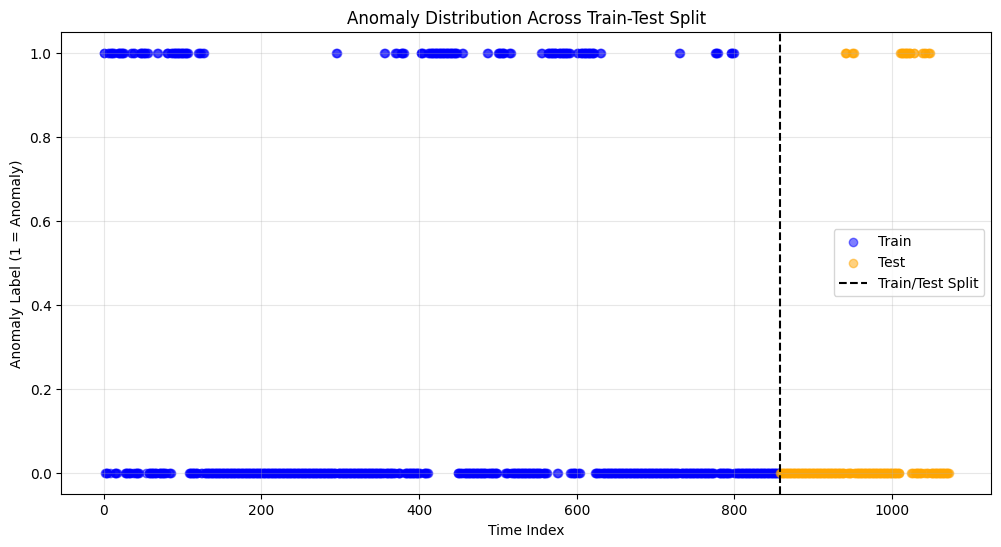

In [9]:
# Data preparation for LSTM Autoencoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import warnings

# Temporarily suppress warnings
warnings.filterwarnings('ignore')

def create_sequences(data, target, seq_length=12):
    """
    Create sequences of data with associated targets for time series modeling.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - target: numpy array of shape (n_samples,)
    - seq_length: number of time steps in each sequence
    
    Returns:
    - X: sequences of shape (n_sequences, seq_length, n_features)
    - y: targets of shape (n_sequences,)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])  # Target is the label of the next point after the sequence
    return np.array(X), np.array(y)

# Prepare data
# 1. Split features and target
X_raw = enriched_df.drop(['Data', 'Y'], axis=1)

# Step 1: Check and report the initial state
inf_count = np.isinf(X_raw.values).sum()
nan_count = np.isnan(X_raw.values).sum()
print(f"Initial state: {inf_count} infinite values, {nan_count} NaN values")

# Step 2: Replace infinities first (before calculating quantiles)
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)

# Step 3: Calculate column medians for later use
col_medians = X_raw.median()

# Step 4: Handle each column separately with more careful bounds
for col in X_raw.columns:
    # Get data without NaNs for percentile calculation
    valid_data = X_raw[col].dropna()
    
    if len(valid_data) > 0:
        # Calculate percentiles from valid data only
        q_low, q_high = valid_data.quantile(0.01), valid_data.quantile(0.99)
        
        # Set reasonable bounds
        iqr = q_high - q_low
        lower_bound = max(q_low - 5 * iqr, -1e6)  # Impose a reasonable minimum
        upper_bound = min(q_high + 5 * iqr, 1e6)  # Impose a reasonable maximum
        
        # Replace NaNs with median and clip values to bounds
        X_raw[col] = X_raw[col].fillna(col_medians[col])
        X_raw[col] = X_raw[col].clip(lower_bound, upper_bound)
    else:
        # If entire column is NaN, fill with 0
        X_raw[col] = 0

# Final check for NaN/inf after cleaning
inf_count = np.isinf(X_raw.values).sum()
nan_count = np.isnan(X_raw.values).sum()
print(f"After cleaning: {inf_count} infinite values, {nan_count} NaN values")

# Convert to numpy array
X_raw = X_raw.values
y = enriched_df['Y'].values
dates = enriched_df['Data']

# 2. Use robust scaling with custom quantile range
scaler = RobustScaler(quantile_range=(10, 90))  # Less extreme than (5, 95)
X_scaled = scaler.fit_transform(X_raw)

# 3. Create sequences for time series forecasting
seq_length = 12  # Use 12 weeks (3 months) of data to predict the next week
X_seq, y_seq = create_sequences(X_scaled, y, seq_length)

# 4. Chronological train-test split (respect time order)
# Use the first 80% for training and the rest for testing
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 5. Create training and testing dates for visualization
dates_seq = dates[seq_length:].reset_index(drop=True)
dates_train, dates_test = dates_seq[:train_size], dates_seq[train_size:]

# 6. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# 7. Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information
print(f"Feature dimension: {X_seq.shape[2]}")
print(f"Sequence length: {seq_length}")
print(f"Training sequences: {len(X_train)}")
print(f"Testing sequences: {len(X_test)}")
print(f"Training period: {dates_train.iloc[0]} to {dates_train.iloc[-1]}")
print(f"Testing period: {dates_test.iloc[0]} to {dates_test.iloc[-1]}")

# Analyze class balance
train_anomaly_pct = y_train.mean() * 100
test_anomaly_pct = y_test.mean() * 100
print(f"Training set anomaly percentage: {train_anomaly_pct:.2f}%")
print(f"Testing set anomaly percentage: {test_anomaly_pct:.2f}%")

# Visualize the train-test split and anomaly distribution
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_train)), y_train, label='Train', alpha=0.5, color='blue')
plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test', alpha=0.5, color='orange')
plt.axvline(x=len(y_train), color='black', linestyle='--', label='Train/Test Split')
plt.title('Anomaly Distribution Across Train-Test Split')
plt.xlabel('Time Index')
plt.ylabel('Anomaly Label (1 = Anomaly)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Re-enable warnings
warnings.filterwarnings('default')

## LSTM Autoencoder Model with Financial Attention

In this section, we'll define our LSTM Autoencoder model with a financial attention mechanism. This model will:
1. Encode sequences using bidirectional LSTM layers
2. Apply an attention mechanism that focuses on important financial patterns
3. Decode the sequence to reconstruct the original data
4. Include a classification head to explicitly predict anomalies

In [10]:
# Define the LSTM Autoencoder with Financial Attention
import torch
import torch.nn as nn
import torch.nn.functional as F

class FinancialAttention(nn.Module):
    """
    Attention mechanism tailored for financial time series data
    """
    def __init__(self, hidden_dim):
        super(FinancialAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention_weights = nn.Linear(hidden_dim, 1)
        
    def forward(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_dim]
        
        # Calculate attention scores
        attention_scores = self.attention_weights(lstm_output)  # [batch_size, seq_len, 1]
        attention_scores = attention_scores.transpose(1, 2)  # [batch_size, 1, seq_len]
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=2)  # [batch_size, 1, seq_len]
        
        # Apply attention weights to LSTM output
        context_vector = torch.bmm(attention_weights, lstm_output)  # [batch_size, 1, hidden_dim]
        context_vector = context_vector.squeeze(1)  # [batch_size, hidden_dim]
        
        return context_vector, attention_weights

class LSTMAutoencoder(nn.Module):
    """
    LSTM Autoencoder with Financial Attention and Classification Head
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.2, bidirectional=True):
        super(LSTMAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.direction_factor = 2 if bidirectional else 1
        
        # Encoder
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Attention mechanism
        self.attention = FinancialAttention(hidden_dim * self.direction_factor)
        
        # Latent representation
        self.fc_encode = nn.Linear(hidden_dim * self.direction_factor, latent_dim)
        
        # Decoder (from latent to sequence)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Output
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
        # Classification head for anomaly detection
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(latent_dim)
        
    def encode(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size, seq_len, _ = x.shape
        
        # Pass through encoder LSTM
        encoder_output, (hidden, cell) = self.encoder_lstm(x)
        # encoder_output shape: [batch_size, seq_len, hidden_dim * direction_factor]
        
        # Apply attention
        context_vector, attention_weights = self.attention(encoder_output)
        # context_vector shape: [batch_size, hidden_dim * direction_factor]
        
        # Project to latent space
        latent = self.fc_encode(context_vector)
        # Apply batch normalization
        latent = self.batch_norm(latent)
        # Apply activation
        latent = F.relu(latent)
        
        return latent, attention_weights
    
    def decode(self, latent, seq_len):
        # latent shape: [batch_size, latent_dim]
        batch_size = latent.shape[0]
        
        # Project from latent space to hidden dim
        hidden_state = self.fc_decode(latent)
        # Expand to sequence
        decoder_input = hidden_state.unsqueeze(1).repeat(1, seq_len, 1)
        # decoder_input shape: [batch_size, seq_len, hidden_dim]
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(latent.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(latent.device)
        
        # Pass through decoder LSTM
        decoder_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        # decoder_output shape: [batch_size, seq_len, hidden_dim]
        
        # Project to input dimension
        reconstructed = self.output_layer(decoder_output)
        # reconstructed shape: [batch_size, seq_len, input_dim]
        
        return reconstructed
    
    def classify(self, latent):
        # latent shape: [batch_size, latent_dim]
        anomaly_pred = self.classifier(latent)
        return anomaly_pred
    
    def forward(self, x):
        # Get batch and sequence dimensions
        batch_size, seq_len, _ = x.shape
        
        # Encode input to latent representation
        latent, attention_weights = self.encode(x)
        
        # Decode latent representation to reconstruct input
        reconstructed = self.decode(latent, seq_len)
        
        # Predict anomaly probability
        anomaly_pred = self.classify(latent)
        
        return reconstructed, anomaly_pred, attention_weights, latent

# Model initialization function
def initialize_model(input_dim, device, hidden_dim=128, latent_dim=64, num_layers=2):
    model = LSTMAutoencoder(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=0.3,
        bidirectional=True
    )
    return model.to(device)

# Create the model
input_dim = X_train.shape[2]  # Number of features
model = initialize_model(input_dim, device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Test the model with a random input
batch_size = 16
seq_len = X_train.shape[1]  # Sequence length
test_input = torch.randn(batch_size, seq_len, input_dim).to(device)
reconstructed, anomaly_pred, attention_weights, latent = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Reconstructed shape: {reconstructed.shape}")
print(f"Anomaly prediction shape: {anomaly_pred.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Latent representation shape: {latent.shape}")

LSTMAutoencoder(
  (encoder_lstm): LSTM(239, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): FinancialAttention(
    (attention_weights): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc_encode): Linear(in_features=256, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (output_layer): Linear(in_features=128, out_features=239, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
    (6): Sigmoid()
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Total parameters: 1099569
Input shape: torch.

## Model Training with Custom Loss Function

In this section, we'll implement the training loop with a custom loss function that:
1. Combines reconstruction error and classification loss
2. Applies asymmetric weighting to penalize missing anomalies more heavily
3. Includes regularization for better generalization

Epoch 1/50 - Loss: 0.8193 (R: 0.4716, C: 0.9339) - Val Loss: 1.1518 (R: 1.1936, C: 0.4308) - Val F1: 0.3377 (P: 0.2708, R: 0.4483) - Val AUC: 0.6563 - Threshold: 0.2985
Epoch 2/50 - Loss: 0.7061 (R: 0.4398, C: 0.7546) - Val Loss: 1.1448 (R: 1.1899, C: 0.5132) - Val F1: 0.2377 (P: 0.1349, R: 1.0000) - Val AUC: 0.2864 - Threshold: 0.0098
Epoch 3/50 - Loss: 0.6442 (R: 0.4311, C: 0.6465) - Val Loss: 1.1139 (R: 1.1774, C: 0.4988) - Val F1: 0.3714 (P: 0.3171, R: 0.4483) - Val AUC: 0.6572 - Threshold: 0.0584
Epoch 4/50 - Loss: 0.5817 (R: 0.4316, C: 0.4825) - Val Loss: 1.2681 (R: 1.1866, C: 1.0252) - Val F1: 0.2377 (P: 0.1349, R: 1.0000) - Val AUC: 0.2937 - Threshold: 0.0000
Epoch 5/50 - Loss: 0.5609 (R: 0.4243, C: 0.4607) - Val Loss: 1.1491 (R: 1.1825, C: 0.6655) - Val F1: 0.2812 (P: 0.2571, R: 0.3103) - Val AUC: 0.4766 - Threshold: 0.0275
Epoch 6/50 - Loss: 0.5459 (R: 0.4239, C: 0.4362) - Val Loss: 1.2249 (R: 1.1757, C: 0.9565) - Val F1: 0.2534 (P: 0.1458, R: 0.9655) - Val AUC: 0.4016 - Thre

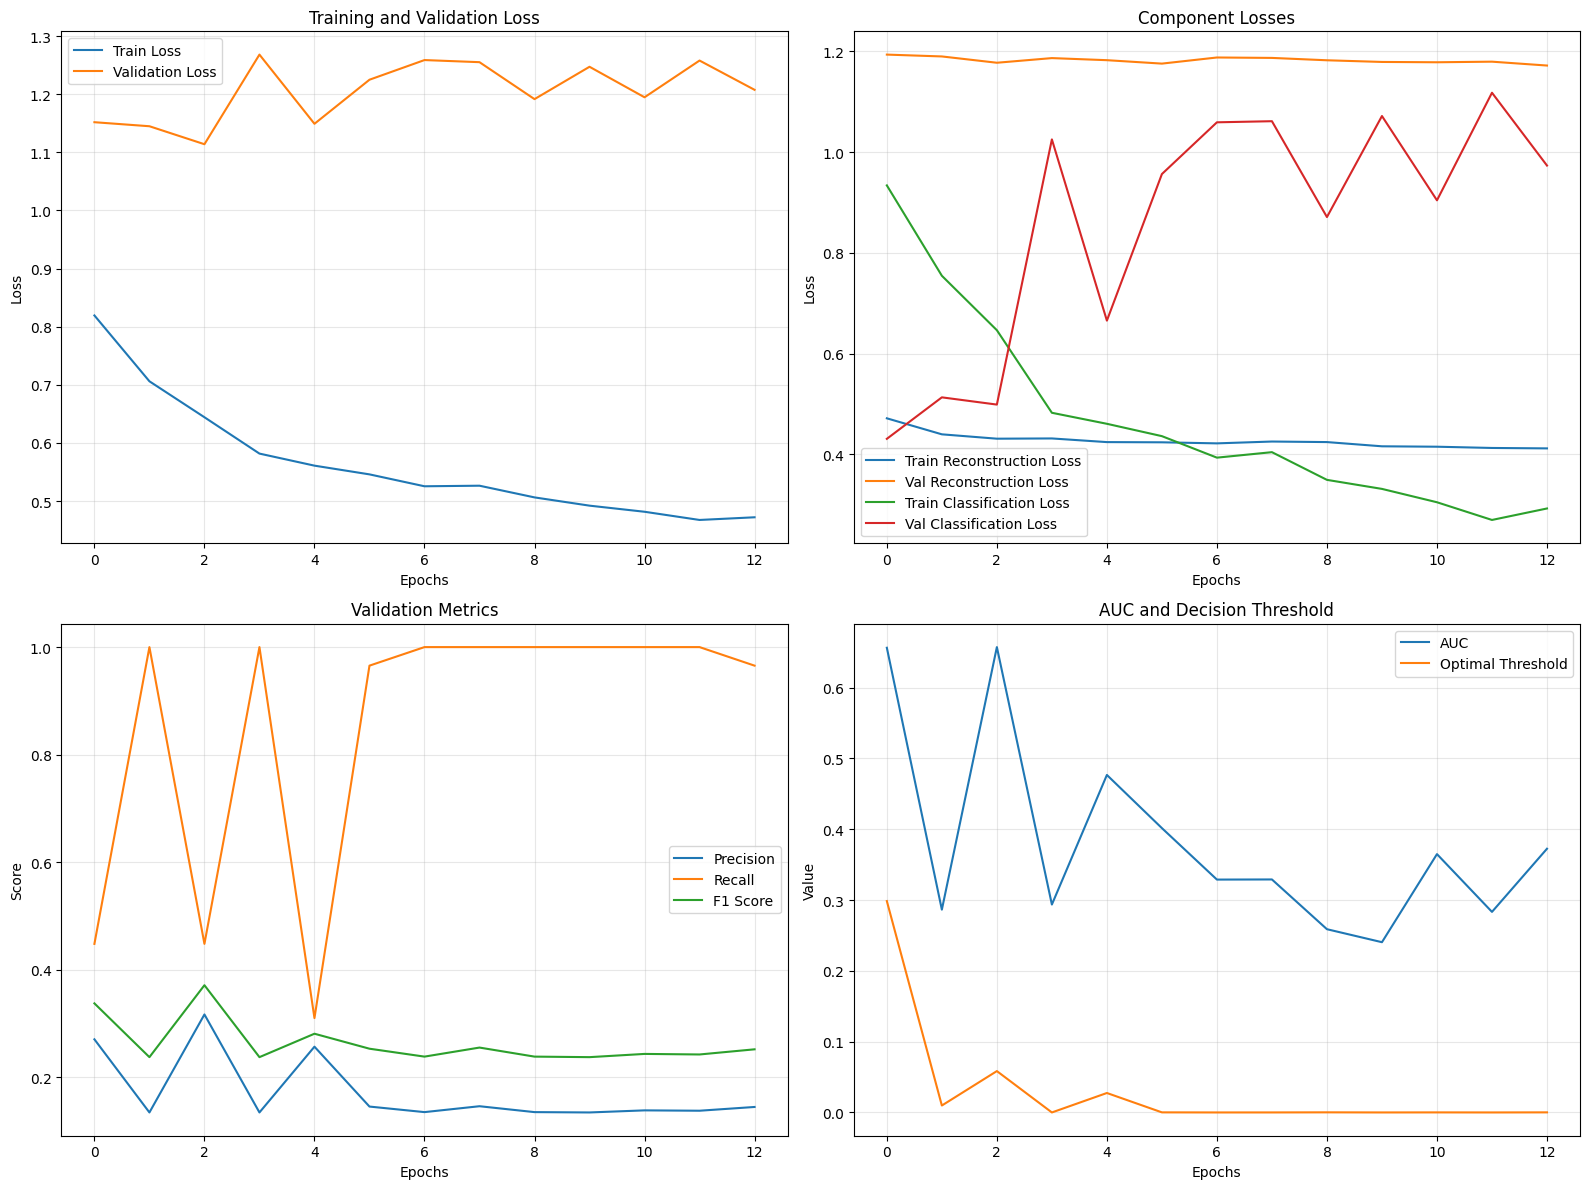

In [12]:
# Define the training function
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc

def train_model(model, train_loader, test_loader, device, num_epochs=100, 
                learning_rate=0.001, beta1=0.9, beta2=0.999, 
                rec_weight=0.7, cls_weight=0.3, lambda_reg=0.001, 
                anomaly_weight=3.0, patience=10):
    """
    Train the LSTM Autoencoder model with custom loss function
    
    Parameters:
    - model: the LSTM Autoencoder model
    - train_loader: DataLoader for training data
    - test_loader: DataLoader for testing data
    - device: device to train on (cuda/mps/cpu)
    - num_epochs: maximum number of training epochs
    - learning_rate: learning rate for optimizer
    - beta1, beta2: Adam optimizer parameters
    - rec_weight: weight for reconstruction loss
    - cls_weight: weight for classification loss
    - lambda_reg: regularization parameter
    - anomaly_weight: weight multiplier for anomaly samples
    - patience: early stopping patience
    
    Returns:
    - Trained model and training history
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    
    # Learning rate scheduler - removed verbose parameter
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Define loss functions
    mse_loss = nn.MSELoss(reduction='none')
    bce_loss = nn.BCELoss(reduction='none')
    
    # Initialize early stopping
    best_val_f1 = 0
    best_model_weights = None
    no_improvement = 0
    
    # Track metrics
    history = {
        'train_loss': [], 'val_loss': [],
        'train_rec_loss': [], 'val_rec_loss': [],
        'train_cls_loss': [], 'val_cls_loss': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': [],
        'val_threshold': []
    }
    
    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_rec_loss = 0
        train_cls_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            reconstructed, anomaly_pred, _, _ = model(data)
            
            # Reconstruction loss
            batch_rec_loss = mse_loss(reconstructed, data).mean(dim=(1, 2))
            
            # Classification loss with asymmetric weighting
            batch_cls_loss = bce_loss(anomaly_pred, target)
            
            # Apply higher weight to anomaly samples
            anomaly_mask = (target == 1).squeeze()
            normal_mask = (target == 0).squeeze()
            
            weighted_cls_loss = torch.zeros_like(batch_cls_loss)
            if anomaly_mask.any():
                weighted_cls_loss[anomaly_mask] = batch_cls_loss[anomaly_mask] * anomaly_weight
            if normal_mask.any():
                weighted_cls_loss[normal_mask] = batch_cls_loss[normal_mask]
            
            batch_cls_loss = weighted_cls_loss.mean()
            
            # L2 regularization
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            
            # Combined loss
            batch_rec_loss_mean = batch_rec_loss.mean()
            loss = rec_weight * batch_rec_loss_mean + cls_weight * batch_cls_loss + lambda_reg * l2_reg
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate metrics
            train_loss += loss.item()
            train_rec_loss += batch_rec_loss_mean.item()
            train_cls_loss += batch_cls_loss.item()
        
        # Calculate average training losses
        train_loss /= len(train_loader)
        train_rec_loss /= len(train_loader)
        train_cls_loss /= len(train_loader)
        
        # Evaluate on validation set
        val_loss, val_rec_loss, val_cls_loss, val_metrics = evaluate_model(
            model, test_loader, device, rec_weight, cls_weight, lambda_reg
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_rec_loss'].append(train_rec_loss)
        history['val_rec_loss'].append(val_rec_loss)
        history['train_cls_loss'].append(train_cls_loss)
        history['val_cls_loss'].append(val_cls_loss)
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])
        history['val_threshold'].append(val_metrics['threshold'])
        
        # Check early stopping
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_weights = model.state_dict().copy()
            no_improvement = 0
        else:
            no_improvement += 1
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss: {train_loss:.4f} (R: {train_rec_loss:.4f}, C: {train_cls_loss:.4f}) - "
              f"Val Loss: {val_loss:.4f} (R: {val_rec_loss:.4f}, C: {val_cls_loss:.4f}) - "
              f"Val F1: {val_metrics['f1']:.4f} (P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f}) - "
              f"Val AUC: {val_metrics['auc']:.4f} - "
              f"Threshold: {val_metrics['threshold']:.4f}")
        
        # Early stopping
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

def evaluate_model(model, test_loader, device, rec_weight=0.7, cls_weight=0.3, lambda_reg=0.001):
    """
    Evaluate the model on the test set
    """
    model.eval()
    val_loss = 0
    val_rec_loss = 0
    val_cls_loss = 0
    
    # Loss functions
    mse_loss = nn.MSELoss(reduction='none')
    bce_loss = nn.BCELoss(reduction='none')
    
    # For metrics calculation
    all_targets = []
    all_preds = []
    all_anomaly_scores = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            reconstructed, anomaly_pred, _, _ = model(data)
            
            # Reconstruction loss
            batch_rec_loss = mse_loss(reconstructed, data).mean(dim=(1, 2))
            
            # Classification loss
            batch_cls_loss = bce_loss(anomaly_pred, target).mean()
            
            # L2 regularization
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            
            # Combined loss
            batch_rec_loss_mean = batch_rec_loss.mean()
            loss = rec_weight * batch_rec_loss_mean + cls_weight * batch_cls_loss + lambda_reg * l2_reg
            
            # Accumulate metrics
            val_loss += loss.item()
            val_rec_loss += batch_rec_loss_mean.item()
            val_cls_loss += batch_cls_loss.item()
            
            # Store predictions and targets for metrics
            all_targets.extend(target.cpu().numpy())
            all_anomaly_scores.extend(anomaly_pred.cpu().numpy())
    
    # Calculate average validation losses
    val_loss /= len(test_loader)
    val_rec_loss /= len(test_loader)
    val_cls_loss /= len(test_loader)
    
    # Convert to numpy arrays
    all_targets = np.array(all_targets).flatten()
    all_anomaly_scores = np.array(all_anomaly_scores).flatten()
    
    # Calculate optimal threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(all_targets, all_anomaly_scores)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Binary predictions using optimal threshold
    all_preds = (all_anomaly_scores >= optimal_threshold).astype(int)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='binary', zero_division=0
    )
    auc_score = roc_auc_score(all_targets, all_anomaly_scores)
    
    # Metrics dictionary
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'threshold': optimal_threshold
    }
    
    return val_loss, val_rec_loss, val_cls_loss, metrics

# Set training parameters
num_epochs = 50  # Max epochs
learning_rate = 0.001
rec_weight = 0.7  # Weight for reconstruction loss
cls_weight = 0.3  # Weight for classification loss
anomaly_weight = 3.0  # Higher weight for anomaly samples
patience = 10  # Early stopping patience

# Train the model
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    rec_weight=rec_weight,
    cls_weight=cls_weight,
    lambda_reg=0.001,
    anomaly_weight=anomaly_weight,
    patience=patience
)

# Plot training and validation loss
plt.figure(figsize=(16, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot reconstruction and classification loss
plt.subplot(2, 2, 2)
plt.plot(history['train_rec_loss'], label='Train Reconstruction Loss')
plt.plot(history['val_rec_loss'], label='Val Reconstruction Loss')
plt.plot(history['train_cls_loss'], label='Train Classification Loss')
plt.plot(history['val_cls_loss'], label='Val Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Component Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot precision, recall, and F1 score
plt.subplot(2, 2, 3)
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.plot(history['val_f1'], label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot AUC and threshold
plt.subplot(2, 2, 4)
plt.plot(history['val_auc'], label='AUC')
plt.plot(history['val_threshold'], label='Optimal Threshold')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('AUC and Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Epoch 1/50 - Loss: 0.5838 (R: 0.5047, C: 0.6629) - Val Loss: 0.9363 (R: 1.2291, C: 0.6434) - Val F1: 0.3714 (P: 0.3171, R: 0.4483) - Val AUC: 0.6848 - Threshold: 0.4700
Epoch 2/50 - Loss: 0.5457 (R: 0.4968, C: 0.5945) - Val Loss: 0.9126 (R: 1.2351, C: 0.5901) - Val F1: 0.5000 (P: 0.4839, R: 0.5172) - Val AUC: 0.7492 - Threshold: 0.4499
Epoch 3/50 - Loss: 0.4734 (R: 0.4895, C: 0.4573) - Val Loss: 0.8079 (R: 1.2356, C: 0.3802) - Val F1: 0.5263 (P: 0.5357, R: 0.5172) - Val AUC: 0.7783 - Threshold: 0.3877
Epoch 4/50 - Loss: 0.4118 (R: 0.4821, C: 0.3415) - Val Loss: 0.7666 (R: 1.2249, C: 0.3083) - Val F1: 0.5106 (P: 0.6667, R: 0.4138) - Val AUC: 0.7870 - Threshold: 0.3926
Epoch 5/50 - Loss: 0.3822 (R: 0.4746, C: 0.2898) - Val Loss: 0.7625 (R: 1.2161, C: 0.3088) - Val F1: 0.5106 (P: 0.6667, R: 0.4138) - Val AUC: 0.7831 - Threshold: 0.3121
Epoch 6/50 - Loss: 0.3632 (R: 0.4699, C: 0.2566) - Val Loss: 0.7554 (R: 1.2124, C: 0.2984) - Val F1: 0.5385 (P: 0.6087, R: 0.4828) - Val AUC: 0.7805 - Thre

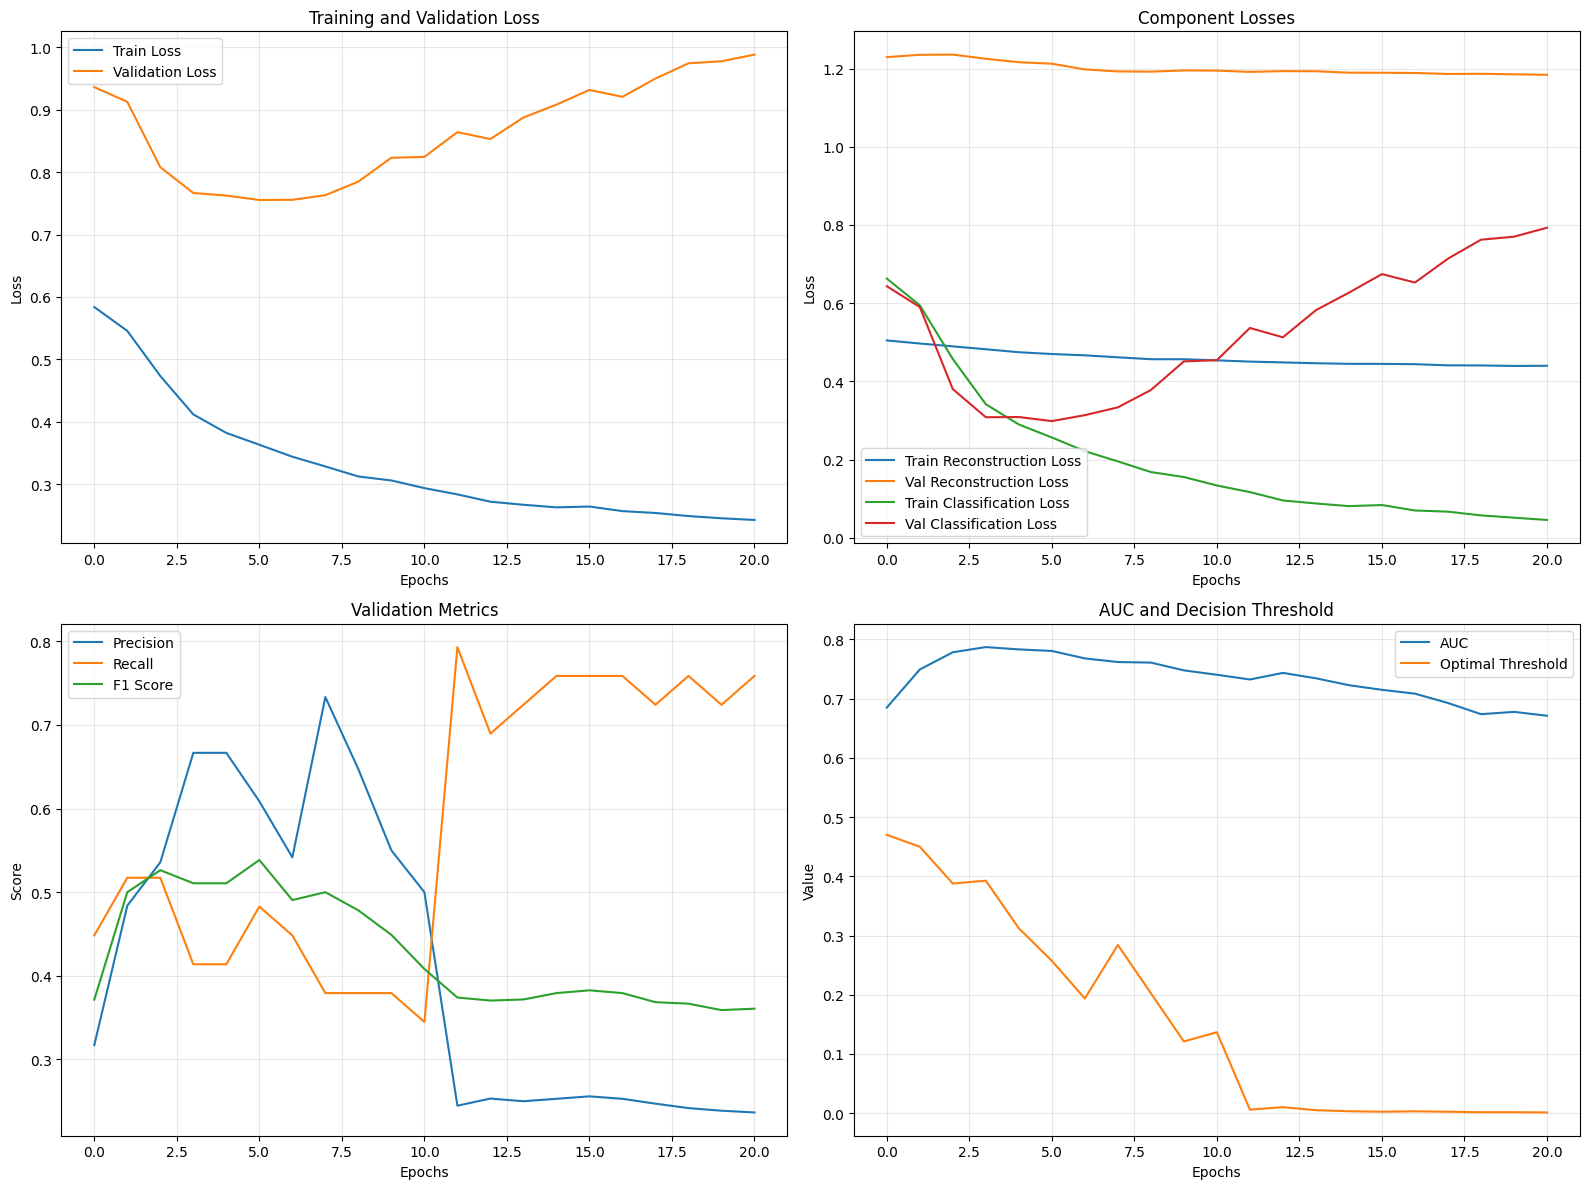

In [13]:
# Define a simpler LSTM Autoencoder model
class SimpleLSTMAutoencoder(nn.Module):
    """
    Simplified LSTM Autoencoder with Classification Head
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout=0.3):
        super(SimpleLSTMAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder - single layer for simplicity
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0
        )
        
        # Latent representation
        self.fc_encode = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder (from latent to sequence)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
        # Classification head for anomaly detection
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size, seq_len, _ = x.shape
        
        # Encode
        encoder_output, (hidden, _) = self.encoder_lstm(x)
        # hidden shape: [1, batch_size, hidden_dim]
        
        # Get last hidden state and project to latent space
        hidden_last = hidden[-1]  # [batch_size, hidden_dim]
        latent = self.fc_encode(hidden_last)  # [batch_size, latent_dim]
        latent = F.relu(latent)
        
        # Decode
        hidden_state = self.fc_decode(latent)  # [batch_size, hidden_dim]
        
        # Repeat hidden state for sequence length
        decoder_input = hidden_state.unsqueeze(1).repeat(1, seq_len, 1)
        # decoder_input shape: [batch_size, seq_len, hidden_dim]
        
        # Initialize hidden and cell states
        h0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        
        # Decode sequence
        decoder_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        # decoder_output shape: [batch_size, seq_len, hidden_dim]
        
        # Output layer
        reconstructed = self.output_layer(decoder_output)
        # reconstructed shape: [batch_size, seq_len, input_dim]
        
        # Classification
        anomaly_pred = self.classifier(latent)
        
        # Return reconstructed sequence, anomaly prediction, and latent representation
        # Setting attention_weights to None as we don't use attention in this model
        return reconstructed, anomaly_pred, None, latent

# Improved training function with more balanced approach
def train_improved_model(model, train_loader, test_loader, device, num_epochs=50, 
                         learning_rate=0.0005, rec_weight=0.5, cls_weight=0.5, 
                         lambda_reg=0.0005, patience=15):
    """
    Train the LSTM Autoencoder model with a more balanced approach
    """
    # Initialize optimizer with lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Define loss functions
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()
    
    # Class weights for weighted BCE loss (to handle class imbalance)
    # Calculate class weights from training data
    pos_weight = torch.tensor([3.0]).to(device)  # Weight for positive class (anomalies)
    weighted_bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Initialize early stopping
    best_val_f1 = 0
    best_model_weights = None
    no_improvement = 0
    
    # Track metrics
    history = {
        'train_loss': [], 'val_loss': [],
        'train_rec_loss': [], 'val_rec_loss': [],
        'train_cls_loss': [], 'val_cls_loss': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': [],
        'val_threshold': []
    }
    
    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_rec_loss = 0
        train_cls_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            reconstructed, anomaly_pred, _, _ = model(data)
            
            # Reconstruction loss
            batch_rec_loss = mse_loss(reconstructed, data)
            
            # Classification loss with class weighting
            batch_cls_loss = bce_loss(anomaly_pred, target)
            
            # Combined loss
            loss = rec_weight * batch_rec_loss + cls_weight * batch_cls_loss
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate metrics
            train_loss += loss.item()
            train_rec_loss += batch_rec_loss.item()
            train_cls_loss += batch_cls_loss.item()
        
        # Calculate average training losses
        train_loss /= len(train_loader)
        train_rec_loss /= len(train_loader)
        train_cls_loss /= len(train_loader)
        
        # Evaluate on validation set
        val_loss, val_rec_loss, val_cls_loss, val_metrics = evaluate_improved_model(
            model, test_loader, device, rec_weight, cls_weight
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_rec_loss'].append(train_rec_loss)
        history['val_rec_loss'].append(val_rec_loss)
        history['train_cls_loss'].append(train_cls_loss)
        history['val_cls_loss'].append(val_cls_loss)
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])
        history['val_threshold'].append(val_metrics['threshold'])
        
        # Check early stopping with a focus on F1 score
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_weights = model.state_dict().copy()
            no_improvement = 0
        else:
            no_improvement += 1
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss: {train_loss:.4f} (R: {train_rec_loss:.4f}, C: {train_cls_loss:.4f}) - "
              f"Val Loss: {val_loss:.4f} (R: {val_rec_loss:.4f}, C: {val_cls_loss:.4f}) - "
              f"Val F1: {val_metrics['f1']:.4f} (P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f}) - "
              f"Val AUC: {val_metrics['auc']:.4f} - "
              f"Threshold: {val_metrics['threshold']:.4f}")
        
        # Early stopping
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

def evaluate_improved_model(model, test_loader, device, rec_weight=0.5, cls_weight=0.5):
    """
    Evaluate the model on the test set
    """
    model.eval()
    val_loss = 0
    val_rec_loss = 0
    val_cls_loss = 0
    
    # Loss functions
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()
    
    # For metrics calculation
    all_targets = []
    all_preds = []
    all_anomaly_scores = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            reconstructed, anomaly_pred, _, _ = model(data)
            
            # Reconstruction loss
            batch_rec_loss = mse_loss(reconstructed, data)
            
            # Classification loss
            batch_cls_loss = bce_loss(anomaly_pred, target)
            
            # Combined loss
            loss = rec_weight * batch_rec_loss + cls_weight * batch_cls_loss
            
            # Accumulate metrics
            val_loss += loss.item()
            val_rec_loss += batch_rec_loss.item()
            val_cls_loss += batch_cls_loss.item()
            
            # Store predictions and targets for metrics
            all_targets.extend(target.cpu().numpy())
            all_anomaly_scores.extend(anomaly_pred.cpu().numpy())
    
    # Calculate average validation losses
    val_loss /= len(test_loader)
    val_rec_loss /= len(test_loader)
    val_cls_loss /= len(test_loader)
    
    # Convert to numpy arrays
    all_targets = np.array(all_targets).flatten()
    all_anomaly_scores = np.array(all_anomaly_scores).flatten()
    
    # Calculate optimal threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(all_targets, all_anomaly_scores)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Binary predictions using optimal threshold
    all_preds = (all_anomaly_scores >= optimal_threshold).astype(int)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='binary', zero_division=0
    )
    auc_score = roc_auc_score(all_targets, all_anomaly_scores)
    
    # Metrics dictionary
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'threshold': optimal_threshold
    }
    
    return val_loss, val_rec_loss, val_cls_loss, metrics

# Create a simplified model
input_dim = X_train.shape[2]  # Number of features
simplified_model = SimpleLSTMAutoencoder(
    input_dim=input_dim,
    hidden_dim=64,  # Reduced hidden dimension
    latent_dim=32,  # Reduced latent dimension
    dropout=0.2
).to(device)

# Set training parameters
num_epochs = 50
learning_rate = 0.0005  # Lower learning rate
rec_weight = 0.5  # Equal weights for reconstruction and classification
cls_weight = 0.5
patience = 15  # More patience

# Train the model
trained_model, history = train_improved_model(
    model=simplified_model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    rec_weight=rec_weight,
    cls_weight=cls_weight,
    lambda_reg=0.0005,  # Lower regularization
    patience=patience
)

# Plot training and validation metrics
plt.figure(figsize=(16, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot reconstruction and classification loss
plt.subplot(2, 2, 2)
plt.plot(history['train_rec_loss'], label='Train Reconstruction Loss')
plt.plot(history['val_rec_loss'], label='Val Reconstruction Loss')
plt.plot(history['train_cls_loss'], label='Train Classification Loss')
plt.plot(history['val_cls_loss'], label='Val Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Component Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot precision, recall, and F1 score
plt.subplot(2, 2, 3)
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.plot(history['val_f1'], label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot AUC and threshold
plt.subplot(2, 2, 4)
plt.plot(history['val_auc'], label='AUC')
plt.plot(history['val_threshold'], label='Optimal Threshold')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('AUC and Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Statistical features shape: (1074, 1673)
Train set shape: (859, 1673)
Test set shape: (215, 1673)
Training Isolation Forest...
Using contamination rate: 0.2305

Training set evaluation:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       661
           1       0.39      0.70      0.50       198

    accuracy                           0.68       859
   macro avg       0.63      0.68      0.63       859
weighted avg       0.77      0.68      0.70       859


Test set evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.13      1.00      0.24        29

    accuracy                           0.13       215
   macro avg       0.07      0.50      0.12       215
weighted avg       0.02      0.13      0.03       215



/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

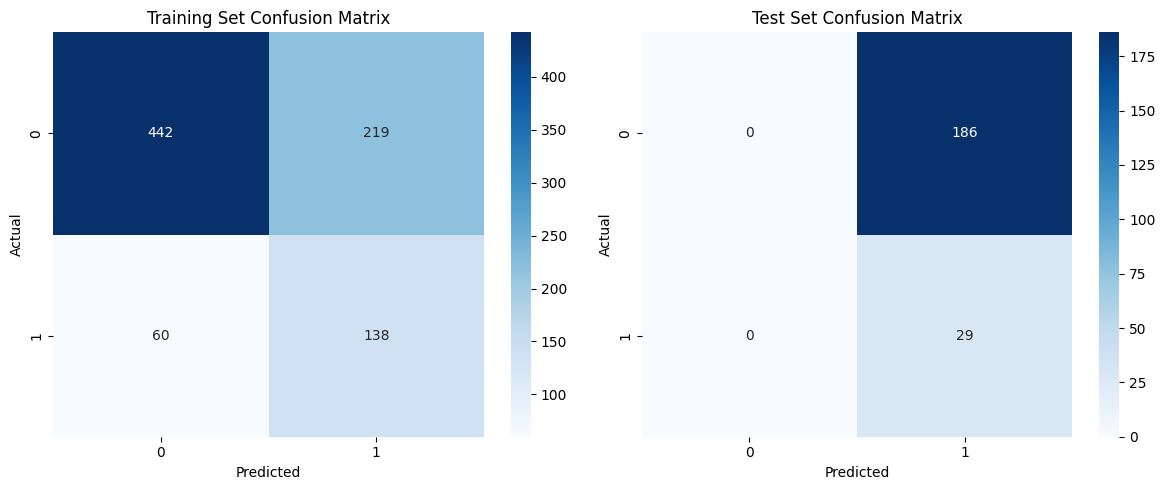

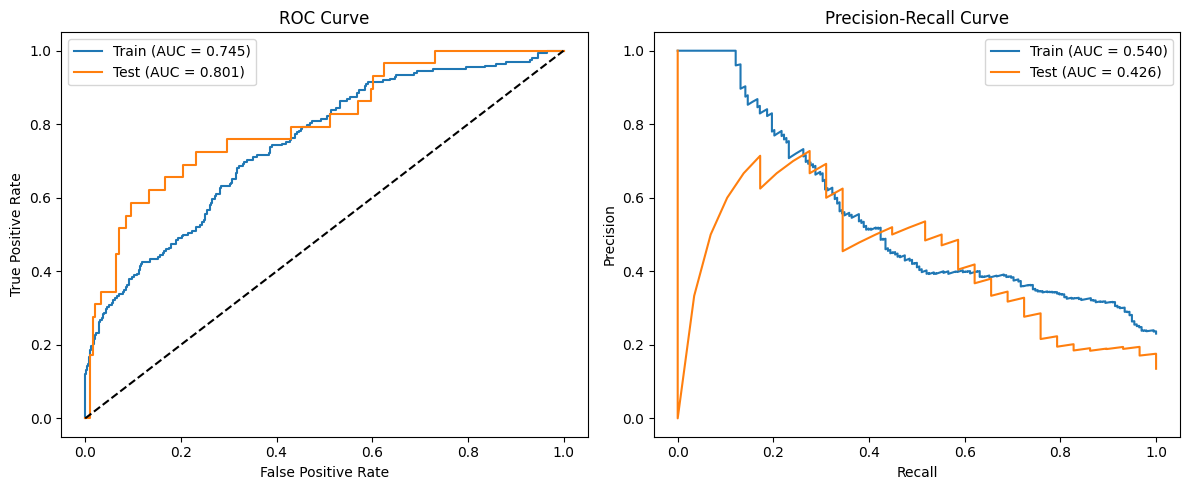

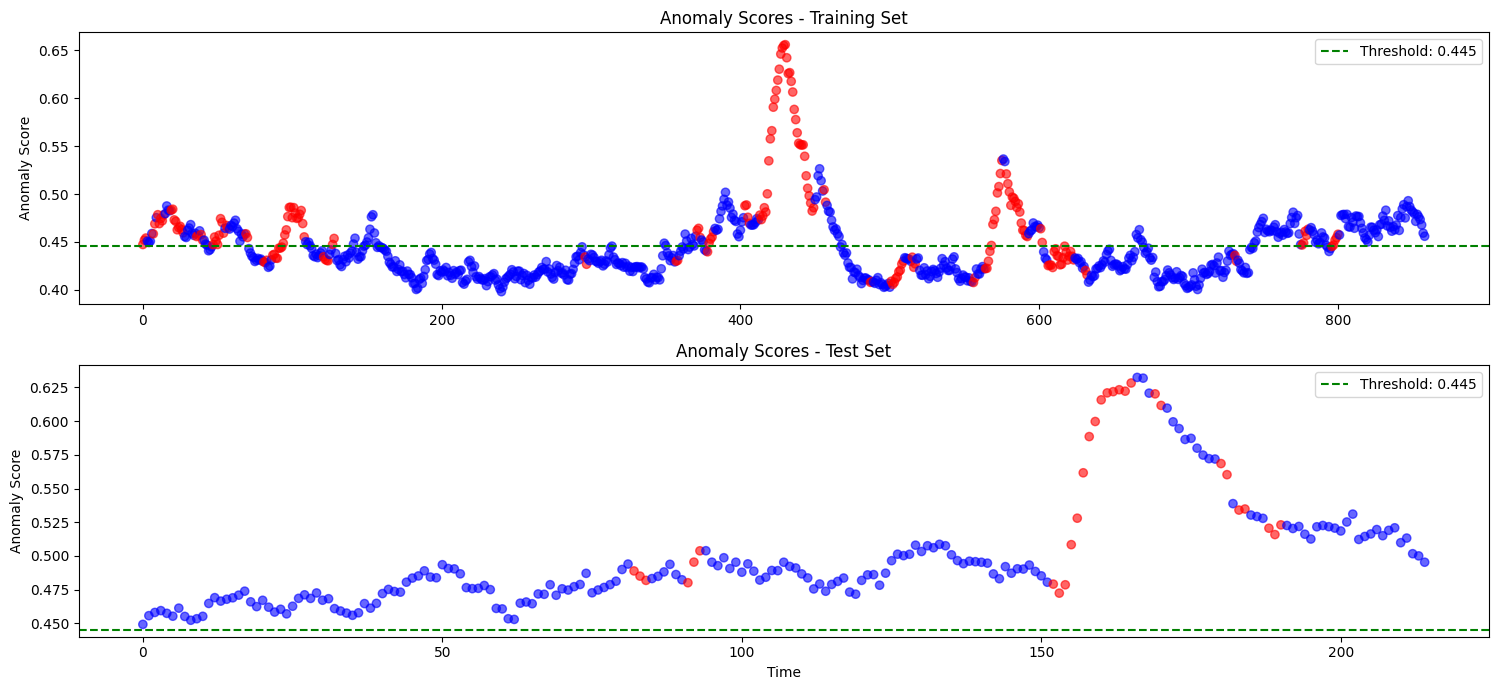

Calculating feature importance (this may take a while)...


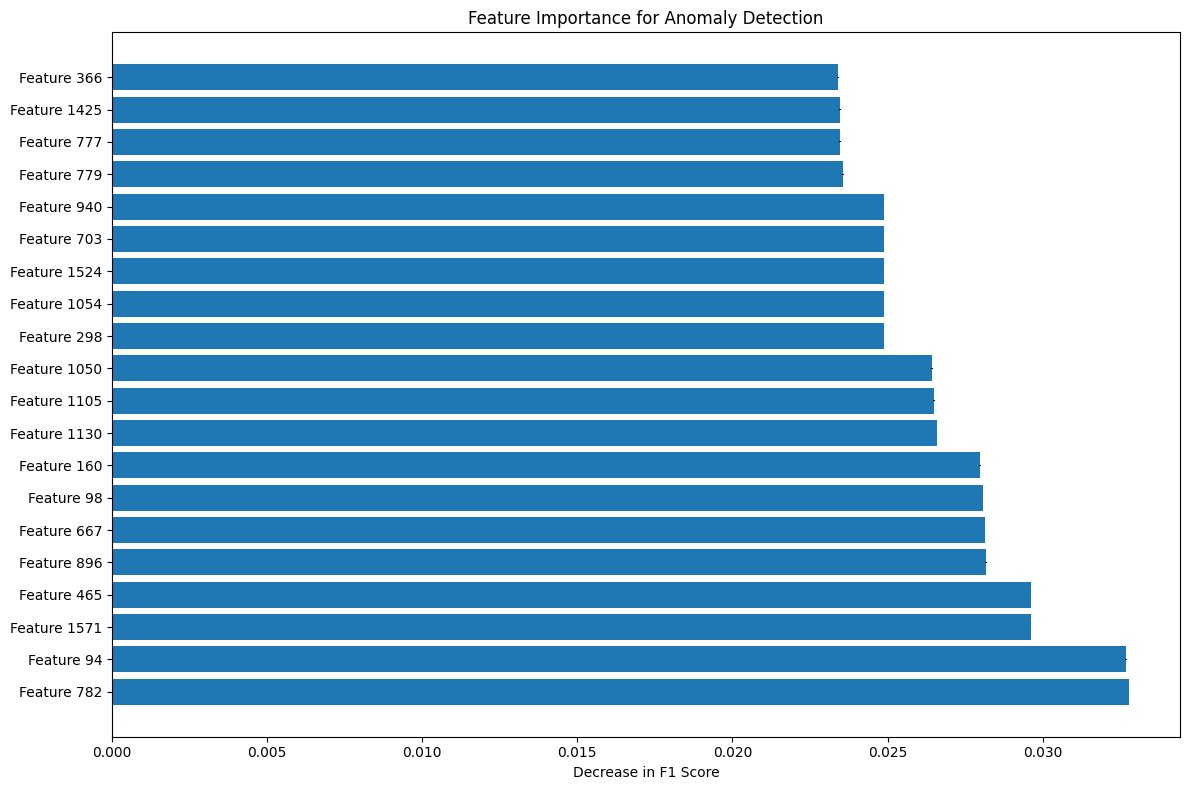

Final F1 Score on Test Set: 0.2377


In [15]:
# Try a different approach: Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, roc_curve, f1_score

# We'll use the enriched features but reshape them for traditional ML
# First, flatten the sequential data by taking statistical features across sequence windows

def extract_statistical_features(X, y, dates, window_size=12):
    """
    Extract statistical features from sequences for use with traditional ML models
    
    Parameters:
    - X: Original features [n_samples, n_features]
    - y: Target labels [n_samples]
    - dates: Dates [n_samples]
    - window_size: Size of sliding window
    
    Returns:
    - X_stats: Statistical features
    - y_stats: Corresponding targets
    - dates_stats: Corresponding dates
    """
    X_stats = []
    y_stats = []
    dates_stats = []
    
    for i in range(len(X) - window_size + 1):
        # Get the window
        X_window = X[i:i+window_size]
        
        # Extract statistical features
        X_mean = np.mean(X_window, axis=0)
        X_std = np.std(X_window, axis=0)
        X_min = np.min(X_window, axis=0)
        X_max = np.max(X_window, axis=0)
        X_median = np.median(X_window, axis=0)
        X_q25 = np.percentile(X_window, 25, axis=0)
        X_q75 = np.percentile(X_window, 75, axis=0)
        
        # Combine features
        features = np.concatenate([X_mean, X_std, X_min, X_max, X_median, X_q25, X_q75])
        X_stats.append(features)
        
        # Target is the label of the next point after the window
        y_stats.append(y[i+window_size-1])
        dates_stats.append(dates[i+window_size-1])
    
    return np.array(X_stats), np.array(y_stats), np.array(dates_stats)

# Extract the raw data from the dataloader
X_raw = X_scaled
y_raw = enriched_df['Y'].values
dates_raw = enriched_df['Data'].values

# Extract statistical features
X_stats, y_stats, dates_stats = extract_statistical_features(X_raw, y_raw, dates_raw)

# Split into train and test sets (chronologically)
train_size = int(len(X_stats) * 0.8)
X_train_stats = X_stats[:train_size]
y_train_stats = y_stats[:train_size]
dates_train_stats = dates_stats[:train_size]

X_test_stats = X_stats[train_size:]
y_test_stats = y_stats[train_size:]
dates_test_stats = dates_stats[train_size:]

print(f"Statistical features shape: {X_stats.shape}")
print(f"Train set shape: {X_train_stats.shape}")
print(f"Test set shape: {X_test_stats.shape}")

# Train Isolation Forest
print("Training Isolation Forest...")
contamination = np.mean(y_train_stats)  # Set contamination to observed anomaly rate
print(f"Using contamination rate: {contamination:.4f}")

isolation_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

isolation_forest.fit(X_train_stats)

# Get anomaly scores and predictions
train_scores = -isolation_forest.score_samples(X_train_stats)  # Negative scores, higher = more anomalous
test_scores = -isolation_forest.score_samples(X_test_stats)

# Find optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_train_stats, train_scores)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

# Make predictions using the optimal threshold
train_preds = (train_scores >= optimal_threshold).astype(int)
test_preds = (test_scores >= optimal_threshold).astype(int)

# Evaluate on training set
print("\nTraining set evaluation:")
print(classification_report(y_train_stats, train_preds))

# Evaluate on test set
print("\nTest set evaluation:")
print(classification_report(y_test_stats, test_preds))

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train_stats, train_preds)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_test_stats, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr_train, tpr_train, _ = roc_curve(y_train_stats, train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test_stats, test_scores)
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc(fpr_train, tpr_train):.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc(fpr_test, tpr_test):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision_train, recall_train, _ = precision_recall_curve(y_train_stats, train_scores)
precision_test, recall_test, _ = precision_recall_curve(y_test_stats, test_scores)
plt.plot(recall_train, precision_train, label=f'Train (AUC = {auc(recall_train, precision_train):.3f})')
plt.plot(recall_test, precision_test, label=f'Test (AUC = {auc(recall_test, precision_test):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Plot anomaly scores over time with highlighted true anomalies
plt.figure(figsize=(15, 7))

# Train set
plt.subplot(2, 1, 1)
plt.scatter(range(len(train_scores)), train_scores, c=['red' if y == 1 else 'blue' for y in y_train_stats], alpha=0.6)
plt.axhline(y=optimal_threshold, color='green', linestyle='--', label=f'Threshold: {optimal_threshold:.3f}')
plt.title('Anomaly Scores - Training Set')
plt.ylabel('Anomaly Score')
plt.legend()

# Test set
plt.subplot(2, 1, 2)
plt.scatter(range(len(test_scores)), test_scores, c=['red' if y == 1 else 'blue' for y in y_test_stats], alpha=0.6)
plt.axhline(y=optimal_threshold, color='green', linestyle='--', label=f'Threshold: {optimal_threshold:.3f}')
plt.title('Anomaly Scores - Test Set')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance using a custom implementation
# Instead of permutation_importance which requires a scoring function
def custom_feature_importance(model, X, y, n_repeats=10):
    """
    Calculate feature importance by shuffling each feature and measuring the impact
    on anomaly detection performance using F1 score.
    """
    # Get baseline scores and predictions
    baseline_scores = -model.score_samples(X)
    precision, recall, thresholds = precision_recall_curve(y, baseline_scores)
    f1_scores_pr = 2 * precision * recall / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores_pr)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    baseline_preds = (baseline_scores >= optimal_threshold).astype(int)
    baseline_f1 = f1_score(y, baseline_preds)
    
    # Initialize importance array
    n_features = X.shape[1]
    importances = np.zeros(n_features)
    importances_std = np.zeros(n_features)
    
    # For each feature
    for i in range(n_features):
        feature_importances = []
        
        # Repeat shuffling
        for j in range(n_repeats):
            # Create a copy of the data
            X_permuted = X.copy()
            
            # Shuffle the current feature
            np.random.seed(j)
            X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
            
            # Get new scores and predictions
            new_scores = -model.score_samples(X_permuted)
            new_preds = (new_scores >= optimal_threshold).astype(int)
            new_f1 = f1_score(y, new_preds)
            
            # Calculate importance as decrease in F1 score
            importance = baseline_f1 - new_f1
            feature_importances.append(importance)
        
        # Calculate mean and std of importance
        importances[i] = np.mean(feature_importances)
        importances_std[i] = np.std(feature_importances)
    
    return importances, importances_std

# Calculate feature importance
print("Calculating feature importance (this may take a while)...")
importances, std = custom_feature_importance(isolation_forest, X_test_stats, y_test_stats, n_repeats=5)

# Get top important features
indices = np.argsort(importances)[::-1]
top_n = 20
top_indices = indices[:top_n]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importances[top_indices], yerr=std[top_indices])
plt.yticks(range(top_n), [f"Feature {i}" for i in top_indices])
plt.title('Feature Importance for Anomaly Detection')
plt.xlabel('Decrease in F1 Score')
plt.tight_layout()
plt.show()

print(f"Final F1 Score on Test Set: {f1_score(y_test_stats, test_preds):.4f}")